In [1]:
import numpy as np

import probnum as pn
import probnum.filtsmooth as pnfs
import probnum.random_variables as pnrv

In [2]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../probnum.mplstyle')

# Bayesian Inference in a Discrete-Discrete State-Space Model: Car Tracking

**TODO**: Description

## Define State-Space Model

### I. Discrete, Linear Dynamics Model

In [3]:
state_dim = 4
observation_dim = 2

In [4]:
delta_t = 0.2
# Define linear transition operator
dynamics_transition_matrix = np.eye(state_dim) + delta_t * np.diag(np.ones(2), 2)
# Define process noise (covariance) matrix
process_noise_matrix = (
    np.diag(np.array([delta_t ** 3 / 3, delta_t ** 3 / 3, delta_t, delta_t]))
    + np.diag(np.array([delta_t ** 2 / 2, delta_t ** 2 / 2]), 2)
    + np.diag(np.array([delta_t ** 2 / 2, delta_t ** 2 / 2]), -2)
)

In [5]:
# Create discrete, Linear Time-Invariant Gaussian dynamics model
dynamics_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=dynamics_transition_matrix, 
    forcevec=np.zeros(state_dim),
    diffmat=process_noise_matrix,
)

### II. Discrete, Linear Measurement Model

In [6]:
measurement_marginal_variance = 0.5
# Define linear measurement matrix (often a projection to observable components of the state vector)
measurement_matrix = np.eye(observation_dim, state_dim)
# Define measurement noise (covariance) matrix
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

In [7]:
measurement_model = pnfs.statespace.DiscreteLTIGaussian(
    dynamicsmat=measurement_matrix,
    forcevec=np.zeros(observation_dim),
    diffmat=measurement_noise_matrix,
)

### III. Initial State Random Variable

In [8]:
mu_0 = np.zeros(state_dim)
sigma_0 = 0.5 * measurement_marginal_variance * np.eye(state_dim)
initial_state_rv = pnrv.Normal(mean=mu_0, cov=sigma_0)

## Generate Data for the State-Space Model

In [9]:
time_grid = np.arange(0., 20., step=delta_t)

In [10]:
latent_states, observations = pnfs.statespace.generate(
    dynmod=dynamics_model,
    measmod=measurement_model,
    initrv=initial_state_rv,
    times=time_grid
)

## Kalman Filtering

### I. Kalman Filter

In [11]:
kalman_filter = pnfs.Kalman(
    dynamics_model=dynamics_model,
    measurement_model=measurement_model,
    initrv=initial_state_rv
)

### II. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [12]:
state_posterior = kalman_filter.filtsmooth(
    dataset=observations,
    times=time_grid,
)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [13]:
posterior_state_rvs = state_posterior.state_rvs      # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean      # Shape: (num_time_points, state_dim)
posterior_state_covs = posterior_state_rvs.cov        # Shape: (num_time_points, state_dim, state_dim)

## Visualize Results

In [14]:
import matplotlib.pyplot as plt

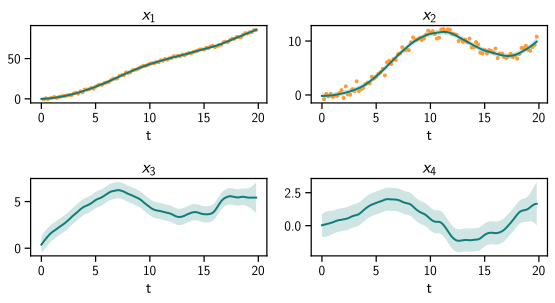

In [25]:
state_fig = plt.figure()
state_fig_gs = gridspec.GridSpec(ncols=2, nrows=2, figure=state_fig)

ax_00 = state_fig.add_subplot(state_fig_gs[0, 0])
ax_01 = state_fig.add_subplot(state_fig_gs[0, 1])
ax_10 = state_fig.add_subplot(state_fig_gs[1, 0])
ax_11 = state_fig.add_subplot(state_fig_gs[1, 1])

# Plot means
mu_x_1, mu_x_2, mu_x_3, mu_x_4 = [posterior_state_means[:, i] for i in range(state_dim)]

ax_00.plot(time_grid, mu_x_1);
ax_01.plot(time_grid, mu_x_2);
ax_10.plot(time_grid, mu_x_3);
ax_11.plot(time_grid, mu_x_4);

# Plot marginal standard deviations
std_x_1, std_x_2, std_x_3, std_x_4 = [np.sqrt(posterior_state_covs[:, i, i]) for i in range(state_dim)]

ax_00.fill_between(time_grid, mu_x_1 - 1.96 * std_x_1,  mu_x_1 + 1.96 * std_x_1, alpha=0.2);
ax_01.fill_between(time_grid, mu_x_2 - 1.96 * std_x_2,  mu_x_2 + 1.96 * std_x_2, alpha=0.2);
ax_10.fill_between(time_grid, mu_x_3 - 1.96 * std_x_3,  mu_x_3 + 1.96 * std_x_3, alpha=0.2);
ax_11.fill_between(time_grid, mu_x_4 - 1.96 * std_x_4,  mu_x_4 + 1.96 * std_x_4, alpha=0.2);

# Plot groundtruth
obs_x_1, obs_x_2 = [observations[:, i] for i in range(observation_dim)]

ax_00.scatter(time_grid[1:], obs_x_1, marker=".");
ax_01.scatter(time_grid[1:], obs_x_2, marker=".");

# Add labels etc.
ax_00.set_xlabel("t")
ax_01.set_xlabel("t")
ax_10.set_xlabel("t")
ax_11.set_xlabel("t")

ax_00.set_title(r"$x_1$")
ax_01.set_title(r"$x_2$")
ax_10.set_title(r"$x_3$")
ax_11.set_title(r"$x_4$")

state_fig.tight_layout()